In [228]:
import os


In [229]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [230]:
data_file = pd.read_csv("Sales_data.csv")
data_file

,date,week,distribution_channel,sold_quantity,net_price
0,2022-07,28,Hợp đồng,1,226937
1,2022-07,29,Phát sinh,1,246682
2,2022-07,28,Bán lẻ,1,142000
3,2022-07,29,Bán lẻ,1,328000
4,2022-07,28,Bán lẻ,1,196000
...,...,...,...,...,...
825842,2022-01,4,Bán lẻ,1,30000
825843,2022-01,53,Bán lẻ,1,0
825844,2022-01,4,Bán lẻ,2,70000
825845,2022-01,1,Bán lẻ,1,1189000


In [231]:
data_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825847 entries, 0 to 825846
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   date                  825847 non-null  object
 1   week                  825847 non-null  int64 
 2   distribution_channel  825847 non-null  object
 3   sold_quantity         825847 non-null  int64 
 4   net_price             825847 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 31.5+ MB


In [232]:
data_file = data_file.drop(['distribution_channel', 'sold_quantity','week'], axis=1)
data_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825847 entries, 0 to 825846
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   date       825847 non-null  object
 1   net_price  825847 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 12.6+ MB


Converting date from obj datatype to daytime datatype

In [233]:
data_file['date'] = pd.to_datetime(data_file['date'], format='%Y-%m')
data_file

,date,net_price
0,2022-07-01,226937
1,2022-07-01,246682
2,2022-07-01,142000
3,2022-07-01,328000
4,2022-07-01,196000
...,...,...
825842,2022-01-01,30000
825843,2022-01-01,0
825844,2022-01-01,70000
825845,2022-01-01,1189000


In [234]:
data_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825847 entries, 0 to 825846
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   date       825847 non-null  datetime64[ns]
 1   net_price  825847 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 12.6 MB


convert data to a Month period-> and sum the numbers of items in each month

In [235]:
data_file['date'] = data_file['date'].dt.to_period("M")
monthly_sales = data_file.groupby('date').sum().reset_index()

convert the resulting data column to timestamp datatype

In [236]:
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()

In [237]:
monthly_sales

,date,net_price
0,2022-01-01,29326229618
1,2022-02-01,12987393541
2,2022-03-01,10097841578
3,2022-04-01,19040355983
4,2022-05-01,12828403373
5,2022-06-01,12755296504
6,2022-07-01,21454756640
7,2022-08-01,26549894727
8,2022-09-01,14739335961
9,2022-10-01,14159630329


Visulization


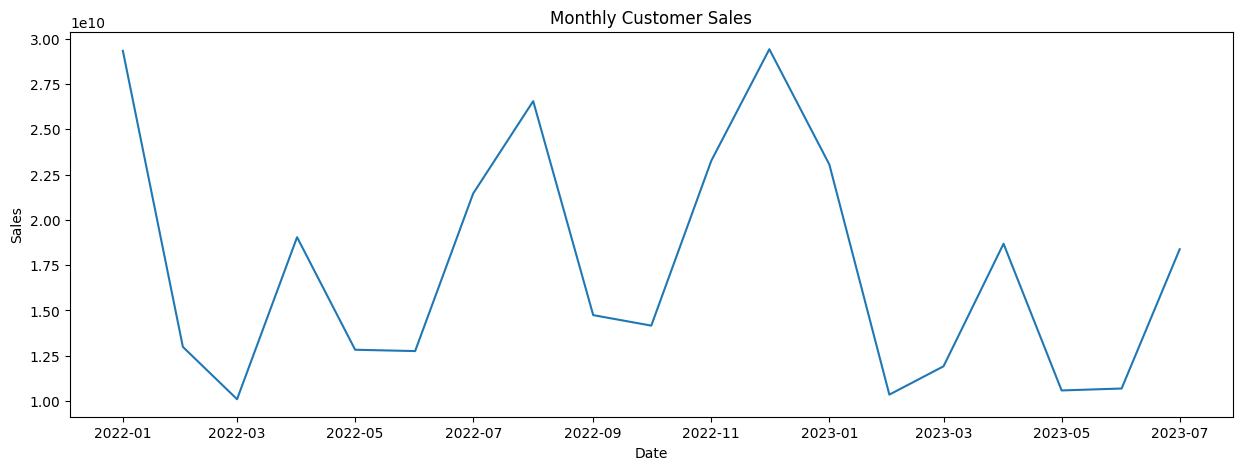

In [238]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['net_price'])
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title("Monthly Customer Sales")
plt.show()


Call sales_diff on the net_price colums to make the sales



In [239]:
monthly_sales['sales_diff'] = monthly_sales['net_price'].diff()
monthly_sales = monthly_sales.dropna()
monthly_sales.head(10)

,date,net_price,sales_diff
1,2022-02-01,12987393541,-1.633884e+10
2,2022-03-01,10097841578,-2.889552e+09
3,2022-04-01,19040355983,8.942514e+09
4,2022-05-01,12828403373,-6.211953e+09
5,2022-06-01,12755296504,-7.310687e+07
6,2022-07-01,21454756640,8.699460e+09
7,2022-08-01,26549894727,5.095138e+09
8,2022-09-01,14739335961,-1.181056e+10
9,2022-10-01,14159630329,-5.797056e+08
10,2022-11-01,23259030103,9.099400e+09


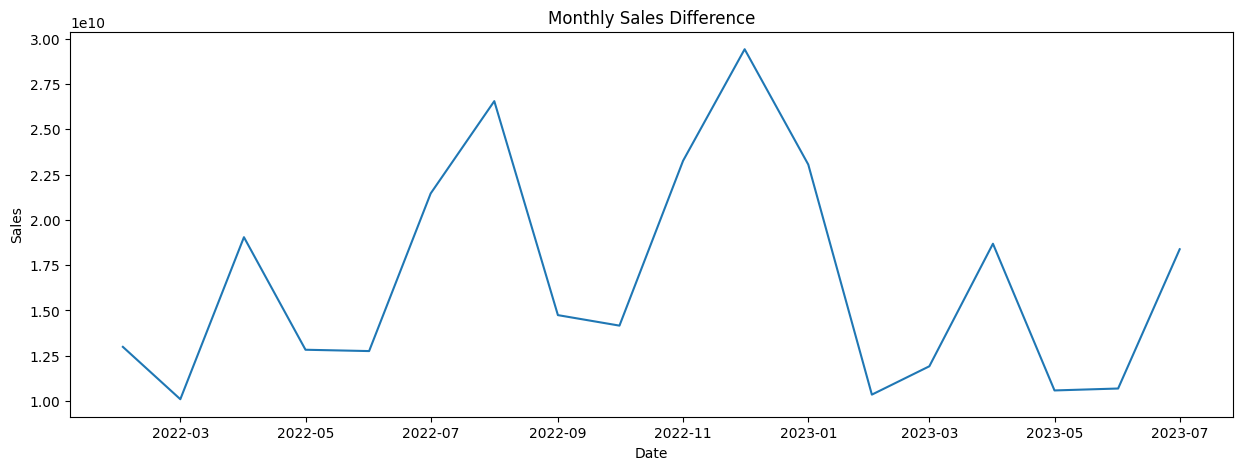

In [240]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['net_price'])
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title("Monthly Sales Difference")
plt.show()


Dropping net_price and date

In [241]:
supervised_data = monthly_sales.drop(['date', 'net_price'], axis=1)
supervised_data

,sales_diff
1,-1.633884e+10
2,-2.889552e+09
3,8.942514e+09
4,-6.211953e+09
5,-7.310687e+07
6,8.699460e+09
7,5.095138e+09
8,-1.181056e+10
9,-5.797056e+08
10,9.099400e+09


superivised_data

In [242]:
for i in range(1,13):
 col_name = 'month_' + str(i)
 supervised_data[col_name] = supervised_data['sales_diff'].shift(i)

supervised_data = supervised_data.dropna().reset_index(drop=True)

supervised_data

,sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,-1.270083e+10,-6.362711e+09,6.155887e+09,9.099400e+09,-5.797056e+08,-1.181056e+10,5.095138e+09,8.699460e+09,-7.310687e+07,-6.211953e+09,8.942514e+09,-2.889552e+09,-1.633884e+10
1,1.564346e+09,-1.270083e+10,-6.362711e+09,6.155887e+09,9.099400e+09,-5.797056e+08,-1.181056e+10,5.095138e+09,8.699460e+09,-7.310687e+07,-6.211953e+09,8.942514e+09,-2.889552e+09
2,6.764139e+09,1.564346e+09,-1.270083e+10,-6.362711e+09,6.155887e+09,9.099400e+09,-5.797056e+08,-1.181056e+10,5.095138e+09,8.699460e+09,-7.310687e+07,-6.211953e+09,8.942514e+09
3,-8.097548e+09,6.764139e+09,1.564346e+09,-1.270083e+10,-6.362711e+09,6.155887e+09,9.099400e+09,-5.797056e+08,-1.181056e+10,5.095138e+09,8.699460e+09,-7.310687e+07,-6.211953e+09
4,1.065339e+08,-8.097548e+09,6.764139e+09,1.564346e+09,-1.270083e+10,-6.362711e+09,6.155887e+09,9.099400e+09,-5.797056e+08,-1.181056e+10,5.095138e+09,8.699460e+09,-7.310687e+07
5,7.687139e+09,1.065339e+08,-8.097548e+09,6.764139e+09,1.564346e+09,-1.270083e+10,-6.362711e+09,6.155887e+09,9.099400e+09,-5.797056e+08,-1.181056e+10,5.095138e+09,8.699460e+09
